### Note: 

After having run some simple codes in our system (which is not GPU enabled, and also Kaggle GPU seems more appropriate) we found out that the data given to us as a Google Drive file [https://drive.google.com/drive/folders/1GYAe8hZB8Si5YSW0akNXBpsELRicE4Hp] is EXACTLY the same as that is here: [https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge].

## Libraries

In [8]:
import pandas as pd                                                 # for panel data analysis
pd.set_option('display.max_columns', None)                          # Unfolding hidden features if the cardinality is high      
pd.set_option('display.max_colwidth', None)                         # Unfolding the max feature width for better clrity      
pd.set_option('display.max_rows', None)                             # Unfolding hidden data points if the cardinality is high
pd.set_option('display.float_format', lambda x: '%.3f' % x)         # To suppress scientific notation over exponential values
#-------------------------------------------------------------------------------------------------------------------------------
import numpy as np                                                  # Importing package numpys (For Numerical Python)
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Importing pyplot interface using matplotlib
from matplotlib.pyplot import figure
figure(figsize=(15, 12), dpi=120)
from matplotlib.pylab import rcParams                               # Backend used for rendering and GUI integration                                               
import seaborn as sns                                               # Importing seaborn library for interactive visualization
#set seaborn plotting aesthetics
sns.set(style='whitegrid')
%matplotlib inline
#-------------------------------------------------------------------------------------------------------------------------------
import os
import csv
import random
import pydicom
#-------------------------------------------------------------------------------------------------------------------------------

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.backend import flatten, sum, clear_session
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, SeparableConv2D, Conv2DTranspose, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.callbacks import CSVLogger
import datetime

## Parse train data as dictionary

In [2]:
# empty dictionary
parsed_dict = {}
# load table
with open(os.path.join('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            
            # save pneumonia location in dictionary
            if filename in parsed_dict:
                parsed_dict[filename].append(location)
            else:
                parsed_dict[filename] = [location]

## Create a helper list of Training Images. And split it into train and val
#### We take random 2560 images in out validation set. 0.10 split.

In [3]:
# load and shuffle img_list
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
img_list = os.listdir(folder)
random.shuffle(img_list)


# split into train and validation img_list
n_valid_samples = 2560 # 0.10 of 26684
train_img_list = img_list[n_valid_samples:]
valid_img_list = img_list[:n_valid_samples]
print('n train samples', len(train_img_list))
print('n valid samples', len(valid_img_list))
n_train_samples = len(img_list) - n_valid_samples

n train samples 24124

n valid samples 2560


## Loss Functions

In [4]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1]) 
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

## Learning Rate Annealing Function

In [5]:
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

## Hyperparameters

In [6]:
BATCH_SIZE = 32
IMG_SIZE = 256
SEED = 42

## Data generator function

In [9]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, img_list, parsed_dict=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.img_list = img_list
        self.parsed_dict = parsed_dict
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.parsed_dict:
            # loop through pneumonia
            for location in self.parsed_dict[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5: #image augmentation parameters
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        img_list = self.img_list[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and img_list
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in img_list]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, img_list
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in img_list]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.img_list)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.img_list) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.img_list) / self.batch_size)

# Network

In [10]:
def downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def skip_conn(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def architecture(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = downsample(channels, x)
        for b in range(n_blocks):
            x = skip_conn(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Compiling and training network

In [11]:
# create train and validation generators
folder = '../input/stage_2_train_images'
train_ds = generator(folder, train_img_list, parsed_dict, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
val_ds = generator(folder, valid_img_list, parsed_dict, batch_size=32, image_size=256, shuffle=False, predict=False)

# create network and compiler
model = architecture(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

history = model.fit_generator(train_ds, validation_data=val_ds, callbacks=[learning_rate], epochs=25, workers=4, use_multiprocessing=True)

Epoch 1/25

753/753 [==============================] - 837s 1s/step - loss: 0.4783 - acc: 0.9631 - mean_iou: 0.6153 - val_loss: 0.4950 - val_acc: 0.9449 - val_mean_iou: 0.5189

Epoch 2/25

753/753 [==============================] - 848s 1s/step - loss: 0.4500 - acc: 0.9664 - mean_iou: 0.6571 - val_loss: 0.5028 - val_acc: 0.9336 - val_mean_iou: 0.4819

Epoch 3/25

753/753 [==============================] - 894s 1s/step - loss: 0.4403 - acc: 0.9674 - mean_iou: 0.6752 - val_loss: 0.4677 - val_acc: 0.9680 - val_mean_iou: 0.6388

Epoch 4/25

753/753 [==============================] - 884s 1s/step - loss: 0.4312 - acc: 0.9686 - mean_iou: 0.6840 - val_loss: 0.4368 - val_acc: 0.9671 - val_mean_iou: 0.6762

Epoch 5/25

753/753 [==============================] - 860s 1s/step - loss: 0.4250 - acc: 0.9693 - mean_iou: 0.6896 - val_loss: 0.4579 - val_acc: 0.9717 - val_mean_iou: 0.7122

Epoch 6/25

753/753 [==============================] - 824s 1s/step - loss: 0.4198 - acc: 0.9702 - mean_iou: 0.7023

## Evolution of loss, accuracy and IoU

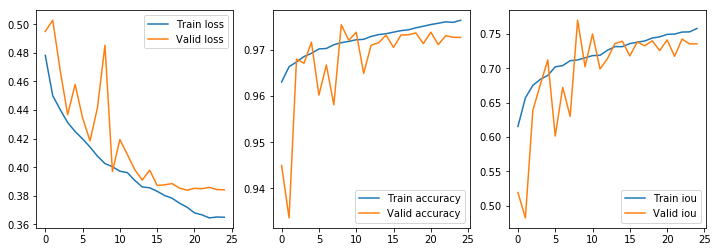

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

## Plotting predictions in one batch

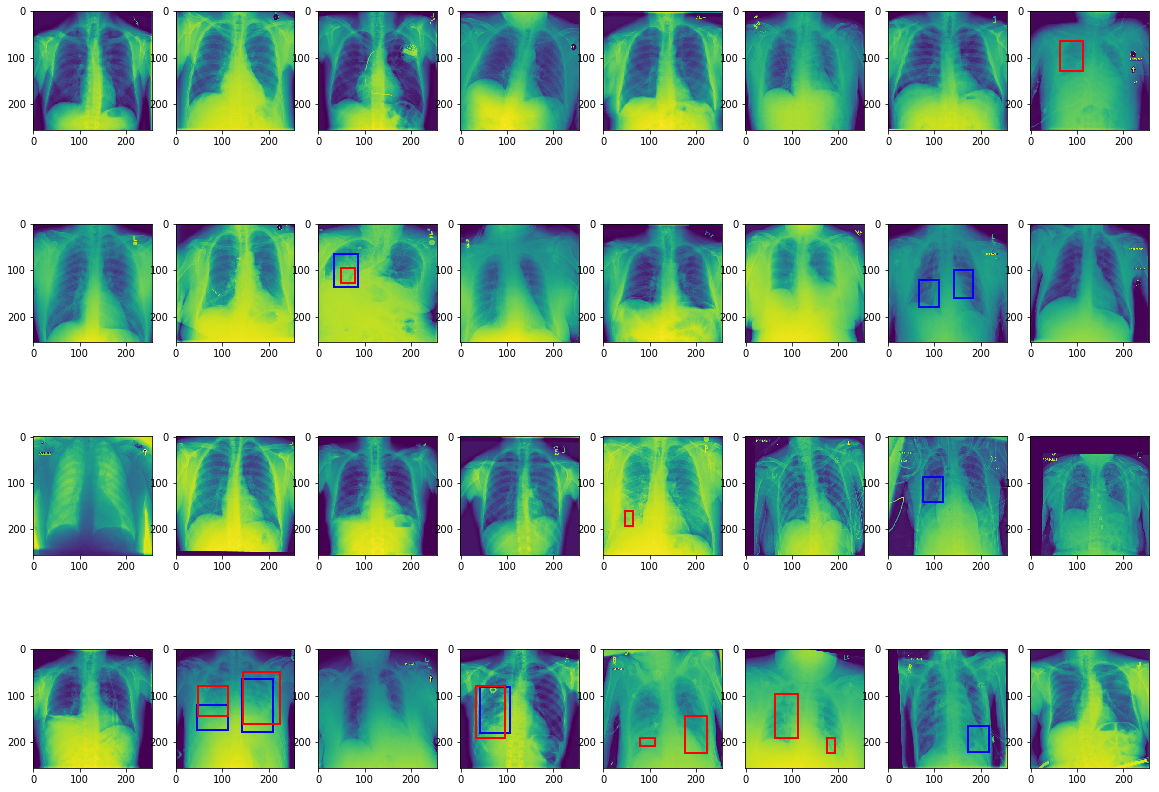

In [13]:
for imgs, msks in val_ds:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break